# **BUSINESS CASE 2: SIEMENS ADVANTA SALES FORECASTING**  


## 🎓 Master’s Program in Data Science & Advanced Analytics 
**Nova IMS** | March 2025   
**Course:** Business Cases with Data Science

## 👥 Team **Group A**  
- **Alice Viegas** | 20240572  
- **Bernardo Faria** | 20240579  
- **Dinis Pinto** | 20240612  
- **Daan van Holten** | 20240681
- **Philippe Dutranoit** | 20240518

## 📊 Goal of the notebook

this notebook is used to predict the market data over 10 months and perform some feature selction 

# imports

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import re
from xgboost import XGBRegressor

# importing relevant 
from Functions import *

import importlib
imported_module = importlib.import_module("Functions")
importlib.reload(imported_module)


<module 'Functions' from '/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Functions.py'>

In [36]:
df_market = pd.read_csv('../Data/df_market.csv')
info_market = pd.read_csv('../Data/info_market.csv')
filtered_market = pd.read_csv('../Data/filtered_info_market.csv')

sales_agg1 = pd.read_csv('../Data/sales_agg1.csv')
sales_agg3 = pd.read_csv('../Data/sales_agg3.csv')
sales_agg4 = pd.read_csv('../Data/sales_agg4.csv')
sales_agg5 = pd.read_csv('../Data/sales_agg5.csv')
sales_agg6 = pd.read_csv('../Data/sales_agg6.csv')
sales_agg8 = pd.read_csv('../Data/sales_agg8.csv')
sales_agg9 = pd.read_csv('../Data/sales_agg9.csv')
sales_agg11 = pd.read_csv('../Data/sales_agg11.csv')
sales_agg12 = pd.read_csv('../Data/sales_agg12.csv')
sales_agg13 = pd.read_csv('../Data/sales_agg13.csv')
sales_agg14 = pd.read_csv('../Data/sales_agg14.csv')
sales_agg16 = pd.read_csv('../Data/sales_agg16.csv')
sales_agg20 = pd.read_csv('../Data/sales_agg20.csv')
sales_agg36 = pd.read_csv('../Data/sales_agg36.csv')

In [37]:
# extract a list of index codes that were find relevant in the preevious notebook
index_codes = filtered_market["Index Code"].tolist()
# only select the columns that were find relevant
df_market = df_market[["date"]+ index_codes]
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 219 non-null    object 
 1   MAB_ELE_PRO156       219 non-null    float64
 2   MAB_ELE_SHP156       219 non-null    float64
 3   MAB_ELE_SHP250       219 non-null    float64
 4   MAB_ELE_PRO392       219 non-null    float64
 5   MAB_ELE_SHP392       219 non-null    float64
 6   MAB_ELE_SHP826       201 non-null    float64
 7   MAB_ELE_SHP840       218 non-null    float64
 8   RohiBASEMET1000_org  219 non-null    float64
 9   RohiMETMIN1000_org   219 non-null    float64
 10  RohiNATGAS1000_org   219 non-null    float64
 11  RohCOPPER1000_org    219 non-null    float64
 12  WKLWEUR840_org       219 non-null    float64
 13  PRI27840_org         219 non-null    float64
 14  PRI27826_org         201 non-null    float64
 15  PRI27380_org         219 non-null    flo

**To change with the right predictor**

# further feature selection

## Preparing the market data for the next septs

we only take the values after 2017 as we don't need as much data as the sales data start in 2018
 
we also drop the coloumn with to many missing values as rightfully imputing them will be difficult and might not be usefull (for future interation and if the project is selected by the business we will manage to find a way to deal with them more effectivly )

In [38]:
# creating a new dataframe for further feature selection
df_market_ft = df_market[(df_market['date'] > "2017-01-01")]
print(df_market_ft.info())
df_market_ft.drop (columns = ["PRI27826_org","MAB_ELE_SHP826"], inplace = True)
df_market_ft.fillna(method='ffill', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 156 to 218
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 63 non-null     object 
 1   MAB_ELE_PRO156       63 non-null     float64
 2   MAB_ELE_SHP156       63 non-null     float64
 3   MAB_ELE_SHP250       63 non-null     float64
 4   MAB_ELE_PRO392       63 non-null     float64
 5   MAB_ELE_SHP392       63 non-null     float64
 6   MAB_ELE_SHP826       45 non-null     float64
 7   MAB_ELE_SHP840       62 non-null     float64
 8   RohiBASEMET1000_org  63 non-null     float64
 9   RohiMETMIN1000_org   63 non-null     float64
 10  RohiNATGAS1000_org   63 non-null     float64
 11  RohCOPPER1000_org    63 non-null     float64
 12  WKLWEUR840_org       63 non-null     float64
 13  PRI27840_org         63 non-null     float64
 14  PRI27826_org         45 non-null     float64
 15  PRI27380_org         63 non-null     float64

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_65171/69304291.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_market_ft.drop (columns = ["PRI27826_org","MAB_ELE_SHP826"], inplace = True)
/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_65171/69304291.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_market_ft.fillna(method='ffill', inplace=True)
/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_65171/69304291.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_market_ft.fillna(method

In [ ]:

# to move to functions.py
def create_lagged_features(df, lags, date_column='date'):
    """
    Creates lagged features for each column in the DataFrame.

    Parameters:
        df (pd.DataFrame): Original DataFrame with datetime column.
        lags (list): List of lag periods to create.
        date_column (str): Name of the datetime column.

    Returns:
        pd.DataFrame: DataFrame with original and lagged features.
    """
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.set_index(date_column)

    lagged_df = df.copy()
    for lag in lags:
        lagged_features = df.shift(lag).add_suffix(f'_lag{lag}')
        lagged_df = pd.concat([lagged_df, lagged_features], axis=1)

    lagged_df = lagged_df.reset_index()
    return lagged_df

# Example usage
lags = [1, 2, 3,4, 5, 6]  # Define the lags you want to create
lagged_df = create_lagged_features(df_market_ft, lags, date_column='date')
lagged_df.set_index('date', inplace=True)
lagged_df.head()

,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_SHP250,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_SHP840,RohiBASEMET1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCOPPER1000_org,...,RohiNATGAS1000_org_lag6,RohCOPPER1000_org_lag6,WKLWEUR840_org_lag6,PRI27840_org_lag6,PRI27380_org_lag6,PRI27250_org_lag6,PRI27276_org_lag6,PRO28392_org_lag6,PRO271000_org_lag6,PRO27392_org_lag6
date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,147.155754,147.155754,99.180980,112.777428,114.462585,104.734557,81.804516,77.940417,68.754551,78.846500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01,204.181230,204.181230,125.071514,139.575382,144.978900,126.300293,81.353145,77.342718,64.424949,77.303257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-01,180.645151,180.645151,101.235472,107.528238,105.387755,111.228944,80.062137,74.041356,67.184583,75.435518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-01,205.540046,205.540046,106.012166,109.307397,107.995416,118.028852,79.081941,72.238722,68.156311,74.316175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-01,231.392533,231.392533,124.007343,126.220610,126.613701,125.498703,79.216548,71.707861,64.963198,75.911444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# make feature selection using XGBRegressor and minimising RMSE
# to be moved to functions.py

def get_important_features(df, target_column="Sales_EUR", top_n=10, threshold=0.05, random_state=1):
    """
    Trains an XGBRegressor that optimizes RMSE, and returns important features.
    
    Parameters:
    - df: pandas DataFrame with features and target
    - target_column: name of the target variable
    - top_n: number of top features to display
    - threshold: minimum importance to include in the final list
    - random_state: seed for reproducibility

    Returns:
    - model: trained XGBRegressor model
    - important_features: list of important feature names above threshold
    - top_features: DataFrame of top_n feature importances
    """

    # 1. Split features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # 2. Train model with RMSE objective
    model = XGBRegressor(objective='reg:squarederror', random_state=random_state)
    model.fit(X, y)
    
    # 3. Feature importances
    importance_df = pd.DataFrame(index=X.columns, data=model.feature_importances_)
    importance_df.sort_values(by=0, inplace=True)
    top_features = importance_df.iloc[-top_n:]
    
    # 4. Filter by threshold
    important_features = top_features[top_features[0] > threshold].index.tolist()
    print(f"Important features with importance higher than {threshold}:", important_features)
    
    # 5. Plot
    top_features.plot(kind='barh', legend=None)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Feature Importances')
    plt.tight_layout()
    plt.show()

    return important_features, top_features

## Product 1

In [46]:
sales_agg1
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lagged_sales1 = create_lagged_features(sales_agg1, lags, date_column='DATE')
lagged_sales1.set_index('DATE', inplace=True)
lagged_sales1.head()

,Sales_EUR,Sales_EUR_lag1,Sales_EUR_lag2,Sales_EUR_lag3,Sales_EUR_lag4,Sales_EUR_lag5,Sales_EUR_lag6,Sales_EUR_lag7,Sales_EUR_lag8,Sales_EUR_lag9,Sales_EUR_lag10
DATE,,,,,,,,,,,
2018-10-01,36098918.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-01,5140760.00,36098918.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-01,37889612.12,5140760.00,36098918.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01,27728148.35,37889612.12,5140760.00,36098918.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,34793163.53,27728148.35,37889612.12,5140760.00,36098918.79,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
lagged_combined_1 = pd.merge(lagged_df, lagged_sales1, left_index=True, right_index=True, how='inner')
lagged_combined_1 = lagged_combined_1.dropna()
lagged_combined_1.head()

,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_SHP250,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_SHP840,RohiBASEMET1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCOPPER1000_org,...,Sales_EUR_lag1,Sales_EUR_lag2,Sales_EUR_lag3,Sales_EUR_lag4,Sales_EUR_lag5,Sales_EUR_lag6,Sales_EUR_lag7,Sales_EUR_lag8,Sales_EUR_lag9,Sales_EUR_lag10
2019-08-01,207.815420,207.815420,89.190446,100.931353,104.476342,127.977412,78.894303,76.048503,51.848054,75.774479,...,37912572.30,39106750.23,38897974.29,39688292.01,33856803.04,34793163.53,27728148.35,37889612.12,5140760.00,36098918.79
2019-09-01,215.853833,215.853833,115.174401,128.197926,132.102871,127.206964,80.463238,77.322808,58.192514,76.435547,...,38042677.05,37912572.30,39106750.23,38897974.29,39688292.01,33856803.04,34793163.53,27728148.35,37889612.12,5140760.00
2019-10-01,226.669259,226.669259,120.928567,107.692863,106.526402,126.201028,80.121698,76.457331,59.115498,76.409667,...,40602780.64,38042677.05,37912572.30,39106750.23,38897974.29,39688292.01,33856803.04,34793163.53,27728148.35,37889612.12
2019-11-01,240.953763,240.953763,110.239446,104.249772,104.162054,114.890035,80.389168,76.215306,63.470692,77.772016,...,39012299.19,40602780.64,38042677.05,37912572.30,39106750.23,38897974.29,39688292.01,33856803.04,34793163.53,27728148.35
2019-12-01,262.913997,262.913997,119.047516,119.779464,120.926433,124.356700,80.713170,77.469997,56.010464,80.653454,...,37323903.07,39012299.19,40602780.64,38042677.05,37912572.30,39106750.23,38897974.29,39688292.01,33856803.04,34793163.53


Important features with importance higher than 0.05: ['PRO271000_org', 'MAB_ELE_PRO156_lag2', 'MAB_ELE_PRO156_lag3', 'MAB_ELE_SHP392', 'PRI27276_org_lag1', 'Sales_EUR_lag6', 'PRO27392_org_lag5']


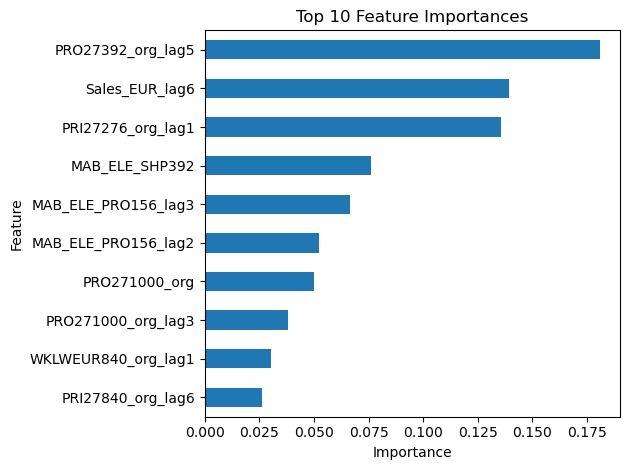

In [52]:
important1, top_10_1= get_important_features(lagged_combined_1, target_column="Sales_EUR", top_n=10, threshold=0.05, random_state=1)

## Product 3

In [60]:
sales_agg3
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lagged_sales3 = create_lagged_features(sales_agg3, lags, date_column='DATE')
lagged_sales3.set_index('DATE', inplace=True)
lagged_sales3.head()

,Sales_EUR,Sales_EUR_lag1,Sales_EUR_lag2,Sales_EUR_lag3,Sales_EUR_lag4,Sales_EUR_lag5,Sales_EUR_lag6,Sales_EUR_lag7,Sales_EUR_lag8,Sales_EUR_lag9,Sales_EUR_lag10
DATE,,,,,,,,,,,
2018-10-01,8089465.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-01,11863001.51,8089465.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-01,8736859.39,11863001.51,8089465.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01,10705300.63,8736859.39,11863001.51,8089465.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,10167796.86,10705300.63,8736859.39,11863001.51,8089465.96,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
lagged_combined_3 = pd.merge(lagged_df, lagged_sales3, left_index=True, right_index=True, how='inner')
lagged_combined_3 = lagged_combined_3.dropna()
lagged_combined_3.head()

,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_SHP250,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_SHP840,RohiBASEMET1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCOPPER1000_org,...,Sales_EUR_lag1,Sales_EUR_lag2,Sales_EUR_lag3,Sales_EUR_lag4,Sales_EUR_lag5,Sales_EUR_lag6,Sales_EUR_lag7,Sales_EUR_lag8,Sales_EUR_lag9,Sales_EUR_lag10
2019-08-01,207.815420,207.815420,89.190446,100.931353,104.476342,127.977412,78.894303,76.048503,51.848054,75.774479,...,13421550.83,11546452.19,12798945.18,12317479.75,11040544.57,10167796.86,10705300.63,8736859.39,11863001.51,8089465.96
2019-09-01,215.853833,215.853833,115.174401,128.197926,132.102871,127.206964,80.463238,77.322808,58.192514,76.435547,...,11359418.30,13421550.83,11546452.19,12798945.18,12317479.75,11040544.57,10167796.86,10705300.63,8736859.39,11863001.51
2019-10-01,226.669259,226.669259,120.928567,107.692863,106.526402,126.201028,80.121698,76.457331,59.115498,76.409667,...,16579668.11,11359418.30,13421550.83,11546452.19,12798945.18,12317479.75,11040544.57,10167796.86,10705300.63,8736859.39
2019-11-01,240.953763,240.953763,110.239446,104.249772,104.162054,114.890035,80.389168,76.215306,63.470692,77.772016,...,11382774.45,16579668.11,11359418.30,13421550.83,11546452.19,12798945.18,12317479.75,11040544.57,10167796.86,10705300.63
2019-12-01,262.913997,262.913997,119.047516,119.779464,120.926433,124.356700,80.713170,77.469997,56.010464,80.653454,...,13826060.48,11382774.45,16579668.11,11359418.30,13421550.83,11546452.19,12798945.18,12317479.75,11040544.57,10167796.86


Important features with importance higher than 0.05: ['PRI27840_org_lag6', 'MAB_ELE_PRO392_lag3', 'PRO27392_org_lag2', 'MAB_ELE_SHP250_lag6', 'MAB_ELE_SHP392']


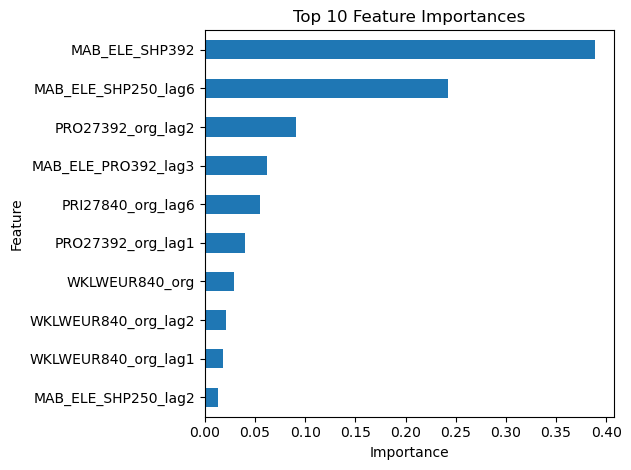

In [62]:
important3, top_10_3= get_important_features(lagged_combined_3, target_column="Sales_EUR", top_n=10, threshold=0.05, random_state=1)

## list of the relavant feature to predict

here we create a list of the feature we will need to predict on the market data in orther to proceed woth the modiling

In [63]:
important_features = important1 + important3# + the other to be done

lagged_pattern = re.compile(r'^(.*)_lag(?:[1-9]|10)$')

# Step 1: Get all non-lagged features directly
non_lagged = [f for f in important_features if not lagged_pattern.match(f)]

# Step 2: Extract base names from lagged features
base_from_lagged = {
    lagged_pattern.match(f).group(1)
    for f in important_features
    if lagged_pattern.match(f)
}

# Step 3: Combine — only add base names from lagged if not already in non-lagged
final_features = list(set(non_lagged) | (base_from_lagged - set(non_lagged)))

print(final_features)

['PRI27840_org', 'PRI27276_org', 'MAB_ELE_PRO392', 'Sales_EUR', 'PRO27392_org', 'MAB_ELE_SHP250', 'PRO271000_org', 'MAB_ELE_PRO156', 'MAB_ELE_SHP392']


# market data prediction

to be changed just an example

In [ ]:
from prophet import Prophet
def forecast_market_features_prophet(market_df, date_column='date', forecast_horizon=10, plot=True):
    """
    Forecasts each column (market feature) in the DataFrame for the next N months using Facebook Prophet.

    Parameters:
        market_df (pd.DataFrame): Market data with datetime column and multiple numeric columns.
        date_column (str): Name of the datetime column.
        forecast_horizon (int): Number of future periods (months) to forecast.
        plot (bool): Whether to plot the forecasts.

    Returns:
        dict: {feature_name: forecast_dataframe_with_future_values}
    """
    forecasts = {}
    market_df = market_df.copy()
    market_df[date_column] = pd.to_datetime(market_df[date_column])
    market_df = market_df.set_index(date_column).asfreq("MS")  # Monthly Start

    for feature in market_df.columns:
        series = market_df[feature].dropna()

        # Format data for Prophet
        df_prophet = pd.DataFrame({
            'ds': series.index,
            'y': series.values
        })

        model = Prophet(yearly_seasonality=True,
                        weekly_seasonality=False,
                        daily_seasonality=False,
                        seasonality_mode='multiplicative',
                        changepoint_prior_scale=0.5)  # Try 0.2, 0.5, 1.0
        model.fit(df_prophet)

        # Future dataframe
        future = model.make_future_dataframe(periods=forecast_horizon, freq='MS')
        forecast = model.predict(future)

        # Store only the forecasted part
        forecast_feature = forecast[['ds', 'yhat']].set_index('ds').iloc[-forecast_horizon:]
        forecasts[feature] = forecast_feature

        # Plot
        if plot:
            plt.figure(figsize=(10, 4))
            plt.plot(df_prophet['ds'], df_prophet['y'], label='History')
            plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')
            plt.title(f"Forecast for '{feature}' using Prophet")
            plt.xlabel("Date")
            plt.ylabel("Value")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return forecasts

In [ ]:
forcast = forecast_market_features_prophet(df_market, date_column='date', forecast_horizon=10, plot=True)

In [ ]:
def append_forecasts_to_market_df(market_df, forecasts, date_column='date'):
    """
    Appends 10-month forecasts to market_df using forecast results per feature.

    Parameters:
        market_df (pd.DataFrame): Original market data.
        forecasts (dict): Dictionary of {feature: pd.Series or pd.DataFrame} with date index.
        date_column (str): Name of the datetime column in original market_df.

    Returns:
        pd.DataFrame: market_df extended with forecasted rows.
    """
    # Make sure the original date column is datetime and index is set
    df = market_df.copy()
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.set_index(date_column).asfreq("MS")

    # Create empty DataFrame for forecasts
    forecast_df = pd.DataFrame(index=next(iter(forecasts.values())).index)

    for feature, forecast_series in forecasts.items():
        if isinstance(forecast_series, pd.DataFrame):
            forecast_df[feature] = forecast_series['yhat']
        else:
            forecast_df[feature] = forecast_series

    # Combine original + forecasted data
    extended_df = pd.concat([df, forecast_df])
    extended_df = extended_df.reset_index().rename(columns={'index': date_column})

    return extended_df

In [ ]:
extended_df = append_forecasts_to_market_df(df_market, forcast, date_column='date')
extended_df.tail(15)